# Druggable proteins selected features - Classes domain 2D

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# remove warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix,accuracy_score, roc_auc_score,f1_score, recall_score, precision_score
from sklearn.utils import class_weight

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process.kernels import RBF
from sklearn.svm import LinearSVC

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.feature_selection import RFECV, VarianceThreshold, SelectKBest, chi2
from sklearn.feature_selection import SelectFromModel, SelectPercentile, f_classif

import seaborn as sns; sns.set() # data visualization library 
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from imblearn.over_sampling import SMOTE

from sklearn.datasets import load_iris
from matplotlib import pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, StratifiedKFold
import numpy as np

import pandas as pd
from sklearn.utils import class_weight
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.externals import joblib

print(__doc__)

2024-06-08 15:36:39,541 [6108] WARNING  py.warnings:110: [JupyterRequire] c:\python37\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)



Automatically created module for IPython interactive environment


In [2]:
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

In [3]:
import joblib

In [4]:
def DataCheckings(df):
    # CHECKINGS ***************************
    # Check the number of data points in the data set
    print("\nData points =", len(df))
    
    # Check the number of columns in the data set
    print("\nColumns (output + features)=",len(df.columns))
    
    # Check the data types
    print("\nData types =", df.dtypes.unique())
    
    # Dataset statistics
    print('\n')
    df.describe()
    
    # print names of columns
    print('Column Names:\n', df.columns)
    
    # see if there are categorical data
    print("\nCategorical features:", df.select_dtypes(include=['O']).columns.tolist())
    
    # Check NA values
    # Check any number of columns with NaN
    print("\nColumns with NaN: ", df.isnull().any().sum(), ' / ', len(df.columns))

    # Check any number of data points with NaN
    print("\nNo of data points with NaN:", df.isnull().any(axis=1).sum(), ' / ', len(df))

In [5]:
def getDataFromDataset(sFile, OutVar):
    # read details file
    print('\n-> Read dataset', sFile)
    df = pd.read_csv(sFile)
    #df = feather.read_dataframe(sFile)
    
    DataCheckings(df)
    
    # remove duplicates!
    df.drop_duplicates(keep=False, inplace=True)
    
    print('Shape', df.shape)
    # print(list(df.columns))

    # select X and Y
    ds_y = df[OutVar]
    ds_X = df.drop(OutVar,axis = 1)
    Xdata = ds_X.values # get values of features
    Ydata = ds_y.values # get output values

    print('Shape X data:', Xdata.shape)
    print('Shape Y data:',Ydata.shape)
    
    # return data for X and Y, feature names as list
    return (Xdata, Ydata, list(ds_X.columns))

In [6]:
def  set_weights(y_data, option='balanced'):
    """Estimate class weights for umbalanced dataset
       If ‘balanced’, class weights will be given by n_samples / (n_classes * np.bincount(y)). 
       If a dictionary is given, keys are classes and values are corresponding class weights. 
       If None is given, the class weights will be uniform """
    cw = class_weight.compute_class_weight(option, np.unique(y_data), y_data)
    w = {i:j for i,j in zip(np.unique(y_data), cw)}
    return w 

In [7]:
# define output variables
outVar = 'Class'

# define list of folds
foldType = 3

# define a label for output files
targetName = 'GS_Outer'

seed = 28
np.random.seed(seed)

## Transform prediction descriptors with the same pipeline

Use the same split for the model 2, standardization, etc.

In [8]:
# get all TC descriptors used for training
sFile = './datasets/ds.Class_TC_ballanced.csv'

# get data from file
Xdata, Ydata, Features = getDataFromDataset(sFile,outVar) # n_sample=100


-> Read dataset ./datasets/ds.Class_TC_ballanced.csv

Data points = 1332

Columns (output + features)= 8001

Data types = [dtype('float64') dtype('int64')]


Column Names:
 Index(['AAA', 'RAA', 'NAA', 'DAA', 'CAA', 'EAA', 'QAA', 'GAA', 'HAA', 'IAA',
       ...
       'KVV', 'MVV', 'FVV', 'PVV', 'SVV', 'TVV', 'WVV', 'YVV', 'VVV', 'Class'],
      dtype='object', length=8001)

Categorical features: []

Columns with NaN:  0  /  8001

No of data points with NaN: 0  /  1332
Shape (1332, 8001)
Shape X data: (1332, 8000)
Shape Y data: (1332,)


In [9]:
# Calculate class weights
class_weights = set_weights(Ydata)
print("Class weights = ", class_weights)

Class weights =  {0: 1.0, 1: 1.0}


In [10]:
outer_cv = StratifiedKFold(n_splits=3,shuffle=True,random_state=seed)

## Get the scaler for the best model and fold

In [11]:
ifold = 0

for train_index, test_index in outer_cv.split(Xdata, Ydata):
    ifold +=1
    
    if ifold ==2: # only model 2
        print("Fold =",ifold)
        X_train, X_test = Xdata[train_index], Xdata[test_index]
        y_train, y_test = Ydata[train_index], Ydata[test_index]

        # Standardize dataset
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)

Fold = 2


In [12]:
print(X_train.shape, X_test.shape)

(888, 8000) (444, 8000)


In [13]:
# save the scaler to file
joblib.dump(scaler, 'scaler.save') # scaler = joblib.load('scaler.save')

['scaler.save']

## Predictions with the best model

We choose model 2 as the best due to the maximum ACC value (AUROC= 0.9752, ACC= 0.937).

In [14]:
# selected features
SelFeats = ['NRA', 'QRA', 'INA', 'MCA', 'YEA', 'THA', 'CSA', 'VYA', 'KNR', 'WDR', 'TER', 'PQR',
            'YGR', 'EHR', 'LIR', 'VSR', 'ERN', 'MDN', 'SDN', 'LHN', 'YIN', 'FFN', 'RSN', 'QSN',
            'FWN', 'ACD', 'WCD', 'MED', 'CHD', 'SHD', 'MLD', 'SMD', 'WPD', 'SSD', 'HTD', 'DWD',
            'VYD', 'KNC', 'NDC', 'IHC', 'VHC', 'GYC', 'MCE', 'NHE', 'ALE', 'HME', 'LPE', 'AWE', 
            'EYE', 'QYE', 'GVE', 'FVE', 'SAQ', 'FNQ', 'MDQ', 'PCQ', 'WEQ', 'RQQ', 'NGQ', 'HLQ', 
            'RMQ', 'DFQ', 'GPQ', 'DSQ', 'YSQ', 'AWQ', 'RVQ', 'QRG', 'HGG', 'TGG', 'KLG', 'NKG', 
            'FPG', 'SSG', 'RTG', 'PTG', 'IVG', 'CDH', 'FDH', 'PDH', 'TQH', 'KHH', 'FHH', 'IFH', 
            'NSH', 'WSH', 'FWH', 'WRI', 'NDI', 'EDI', 'FEI', 'WEI', 'WQI', 'MGI', 'PMI', 'AAL',
            'EKL', 'IKL', 'FKL', 'GPL', 'ESL', 'DVL', 'MVL', 'VVL', 'GNK', 'HNK', 'HDK', 'HCK', 
            'EQK', 'DHK', 'QLK', 'EKK', 'SMK', 'FFK', 'QSK', 'EWK', 'AVK', 'WRM', 'WNM', 'REM',
            'WQM', 'SHM', 'LLM', 'SMM', 'NFM', 'TSM', 'RWM', 'GYM', 'KYM', 'VYM', 'HVM', 'IVM', 
            'LDF', 'YQF', 'NGF', 'HGF', 'FWF', 'FAP', 'FNP', 'PEP', 'SQP', 'QGP', 'VHP', 'PLP', 
            'HKP', 'NPP', 'QPP', 'STP', 'TTP', 'KWP', 'YWP', 'SRS', 'HDS', 'WDS', 'HCS', 'LES',
            'DHS', 'SHS', 'PSS', 'SSS', 'LWS', 'LAT', 'DRT', 'GRT', 'IRT', 'INT', 'VQT', 'NLT',
            'CLT', 'KKT', 'YTT', 'QWT', 'FYT', 'KCW', 'QGW', 'VGW', 'MIW', 'IKW', 'RFW', 'DFW',
            'HVW', 'KVW', 'NRY', 'CHY', 'DMY', 'YPY', 'YAV', 'SRV', 'ENV', 'HNV', 'GEV', 'QGV',
            'HGV', 'TGV', 'WHV', 'LLV', 'IMV', 'DSV', 'TSV', 'QYV']
print(len(SelFeats))

200


### Get dataset of the model - full TC descriptors

In [15]:
# dataset of the model
df = pd.read_csv('./datasets/ds.Class_TC_ballanced.csv')
    
# remove duplicates!
df.drop_duplicates(keep=False, inplace=True)
    
print('Shape', df.shape)

Shape (1332, 8001)


In [16]:
df

,AAA,RAA,NAA,DAA,CAA,EAA,QAA,GAA,HAA,IAA,...,KVV,MVV,FVV,PVV,SVV,TVV,WVV,YVV,VVV,Class
0,0.011173,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
1,0.043478,0.008696,0.000000,0.0,0.000000,0.008696,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
2,0.005580,0.001116,0.000000,0.0,0.001116,0.002232,0.000000,0.002232,0.000000,0.001116,...,0.000000,0.000000,0.000000,0.001116,0.000000,0.000000,0.000000,0.000000,0.000000,1
3,0.007958,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
4,0.005556,0.000000,0.000000,0.0,0.002778,0.002778,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1327,0.000000,0.000096,0.000000,0.0,0.000096,0.000000,0.000000,0.000000,0.000000,0.000096,...,0.000096,0.000096,0.000096,0.000192,0.000000,0.000096,0.000096,0.002429,0.000000,0
1328,0.001378,0.000000,0.000703,0.0,0.000000,0.000000,0.000014,0.000007,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000007,0.000007,0.000000,0.000689,0.000000,0
1329,0.000956,0.000000,0.000000,0.0,0.000000,0.000023,0.000023,0.000023,0.000979,0.000023,...,0.000000,0.000000,0.000000,0.000023,0.000000,0.000000,0.000000,0.000000,0.000023,0
1330,0.000000,0.000168,0.000168,0.0,0.000000,0.000000,0.000000,0.003092,0.000168,0.000000,...,0.000000,0.000168,0.000168,0.000337,0.000000,0.002924,0.000000,0.000000,0.000000,0


### Get the best predicted proteins

In [17]:
# get prediction data
df1 = pd.read_csv('./PREDICTIONS/TC_seqs.Screening_1_Cancer_Driver_Genes.csv')
df2 = pd.read_csv('./PREDICTIONS/TC_seqs.Screening_2_OncoOmics_Genes.csv')
df3 = pd.read_csv('./PREDICTIONS/TC_seqs.Screening_3_RBPs.csv')
    
# remove duplicates!
df1.drop_duplicates(keep=False, inplace=True)
df2.drop_duplicates(keep=False, inplace=True)
df3.drop_duplicates(keep=False, inplace=True)
    
print('Shape df1', df1.shape)
print('Shape df2', df2.shape)
print('Shape df3', df3.shape)

Shape df1 (2359, 8004)
Shape df2 (231, 8004)
Shape df3 (1369, 8004)


In [18]:
dfx = pd.concat([df1,df2,df3],ignore_index=True)
print(list(dfx.columns))

['Unnamed: 0', 'V3', 'AAA', 'RAA', 'NAA', 'DAA', 'CAA', 'EAA', 'QAA', 'GAA', 'HAA', 'IAA', 'LAA', 'KAA', 'MAA', 'FAA', 'PAA', 'SAA', 'TAA', 'WAA', 'YAA', 'VAA', 'ARA', 'RRA', 'NRA', 'DRA', 'CRA', 'ERA', 'QRA', 'GRA', 'HRA', 'IRA', 'LRA', 'KRA', 'MRA', 'FRA', 'PRA', 'SRA', 'TRA', 'WRA', 'YRA', 'VRA', 'ANA', 'RNA', 'NNA', 'DNA', 'CNA', 'ENA', 'QNA', 'GNA', 'HNA', 'INA', 'LNA', 'KNA', 'MNA', 'FNA', 'PNA', 'SNA', 'TNA', 'WNA', 'YNA', 'VNA', 'ADA', 'RDA', 'NDA', 'DDA', 'CDA', 'EDA', 'QDA', 'GDA', 'HDA', 'IDA', 'LDA', 'KDA', 'MDA', 'FDA', 'PDA', 'SDA', 'TDA', 'WDA', 'YDA', 'VDA', 'ACA', 'RCA', 'NCA', 'DCA', 'CCA', 'ECA', 'QCA', 'GCA', 'HCA', 'ICA', 'LCA', 'KCA', 'MCA', 'FCA', 'PCA', 'SCA', 'TCA', 'WCA', 'YCA', 'VCA', 'AEA', 'REA', 'NEA', 'DEA', 'CEA', 'EEA', 'QEA', 'GEA', 'HEA', 'IEA', 'LEA', 'KEA', 'MEA', 'FEA', 'PEA', 'SEA', 'TEA', 'WEA', 'YEA', 'VEA', 'AQA', 'RQA', 'NQA', 'DQA', 'CQA', 'EQA', 'QQA', 'GQA', 'HQA', 'IQA', 'LQA', 'KQA', 'MQA', 'FQA', 'PQA', 'SQA', 'TQA', 'WQA', 'YQA', 'VQA',

In [19]:
dfx

,Unnamed: 0,V3,AAA,RAA,NAA,DAA,CAA,EAA,QAA,GAA,...,MVV,FVV,PVV,SVV,TVV,WVV,YVV,VVV,V1,V2
0,1,MAAAAAAATTAACSSGSAGTDAAGASGLQQPPPQPQPQPAAAAPAQ...,0.014263,0.000000,0.00000,0.001585,0.000000,0.000000,0.001585,0.00317,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,Q8TDN4,CABL1_HUMAN CDK5 and ABL1 enzyme substrate 1 O...
1,2,MAAAAAAAVGGQQPSQPELPAPGLALDKAATAAHLKAALSRPDNRA...,0.004772,0.000000,0.00000,0.000530,0.001060,0.000000,0.000000,0.00053,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000530,Q6ZT12,UBR3_HUMAN E3 ubiquitin-protein ligase UBR3 OS...
2,3,MAAAAAAGAGPEMVRGQVFDVGPRYTNLSYIGEGAYGMVCSAYDNV...,0.011173,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,P28482,MK01_HUMAN Mitogen-activated protein kinase 1 ...
3,4,MAAAAAALSGAGTPPAGGGAGGGGAGGGGSPPGGWAVARLEGREFE...,0.007599,0.000000,0.00152,0.000000,0.000000,0.000000,0.000000,0.00304,...,0.0,0.0,0.001520,0.0,0.0,0.0,0.000000,0.000000,Q01167,FOXK2_HUMAN Forkhead box protein K2 OS=Homo sa...
4,5,MAAAAAEQQQFYLLLGNLLSPDNVVRKQAEETYENIPGQSKITFLL...,0.007306,0.000000,0.00000,0.000000,0.000000,0.000913,0.001826,0.00000,...,0.0,0.0,0.000913,0.0,0.0,0.0,0.000000,0.000000,O00410,IPO5_HUMAN Importin-5 OS=Homo sapiens OX=9606 ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3954,1365,MYRSGERLLGSHALPAEQRDFLPLETTNNNNNHHQPGAWARRAGSS...,0.000000,0.003509,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.001754,0.000000,Q8NDF8,PAPD5_HUMAN Terminal nucleotidyltransferase 4A...
3955,1366,MYRTKVGLKDRQQLYKLIISQLLYDGYISIANGLINEIKPQSVCAP...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,Q05048,CSTF1_HUMAN Cleavage stimulation factor subuni...
3956,1367,MYSGAGPALAPPAPPPPIQGYAFKPPPRPDFGTSGRTIKLQANFFE...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.001167,Q9UKV8,AGO2_HUMAN Protein argonaute-2 OS=Homo sapiens...
3957,1368,MYTITKGPSKLVAQRRTGPTQQQVEGRLGELLKCRQPAPPTSQPPR...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,Q9BUT9,MCRI2_HUMAN MAPK regulated corepressor interac...


In [20]:
# create extra column gene
dfx['gene'] = ''

In [21]:
# extract the gene name from V2
for index, row in dfx.iterrows():
    if "GN=" in row['V2']:
        gene = row['V2'].split("GN=")[1].split(" ")[0]
        dfx.loc[index, 'gene'] = gene

In [22]:
dfx

,Unnamed: 0,V3,AAA,RAA,NAA,DAA,CAA,EAA,QAA,GAA,...,FVV,PVV,SVV,TVV,WVV,YVV,VVV,V1,V2,gene
0,1,MAAAAAAATTAACSSGSAGTDAAGASGLQQPPPQPQPQPAAAAPAQ...,0.014263,0.000000,0.00000,0.001585,0.000000,0.000000,0.001585,0.00317,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,Q8TDN4,CABL1_HUMAN CDK5 and ABL1 enzyme substrate 1 O...,CABLES1
1,2,MAAAAAAAVGGQQPSQPELPAPGLALDKAATAAHLKAALSRPDNRA...,0.004772,0.000000,0.00000,0.000530,0.001060,0.000000,0.000000,0.00053,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000530,Q6ZT12,UBR3_HUMAN E3 ubiquitin-protein ligase UBR3 OS...,UBR3
2,3,MAAAAAAGAGPEMVRGQVFDVGPRYTNLSYIGEGAYGMVCSAYDNV...,0.011173,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,P28482,MK01_HUMAN Mitogen-activated protein kinase 1 ...,MAPK1
3,4,MAAAAAALSGAGTPPAGGGAGGGGAGGGGSPPGGWAVARLEGREFE...,0.007599,0.000000,0.00152,0.000000,0.000000,0.000000,0.000000,0.00304,...,0.0,0.001520,0.0,0.0,0.0,0.000000,0.000000,Q01167,FOXK2_HUMAN Forkhead box protein K2 OS=Homo sa...,FOXK2
4,5,MAAAAAEQQQFYLLLGNLLSPDNVVRKQAEETYENIPGQSKITFLL...,0.007306,0.000000,0.00000,0.000000,0.000000,0.000913,0.001826,0.00000,...,0.0,0.000913,0.0,0.0,0.0,0.000000,0.000000,O00410,IPO5_HUMAN Importin-5 OS=Homo sapiens OX=9606 ...,IPO5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3954,1365,MYRSGERLLGSHALPAEQRDFLPLETTNNNNNHHQPGAWARRAGSS...,0.000000,0.003509,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.0,0.000000,0.0,0.0,0.0,0.001754,0.000000,Q8NDF8,PAPD5_HUMAN Terminal nucleotidyltransferase 4A...,TENT4B
3955,1366,MYRTKVGLKDRQQLYKLIISQLLYDGYISIANGLINEIKPQSVCAP...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,Q05048,CSTF1_HUMAN Cleavage stimulation factor subuni...,CSTF1
3956,1367,MYSGAGPALAPPAPPPPIQGYAFKPPPRPDFGTSGRTIKLQANFFE...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.001167,Q9UKV8,AGO2_HUMAN Protein argonaute-2 OS=Homo sapiens...,AGO2
3957,1368,MYTITKGPSKLVAQRRTGPTQQQVEGRLGELLKCRQPAPPTSQPPR...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,Q9BUT9,MCRI2_HUMAN MAPK regulated corepressor interac...,MCRIP2


In [23]:
# remove column
dfx.drop('Unnamed: 0', axis=1, inplace=True)

In [24]:
# remove column
dfx.drop('V3', axis=1, inplace=True)

In [25]:
# remove column
dfx.drop('V2', axis=1, inplace=True)

In [26]:
# list with the final genes as the best predictions in the paper
best = ["CDKN2A", "BCL10", "ACVR1", "CASP8", "JAG1", "TSC1", "NBN",
        "PREX2", "PPP2R1A", "DNM2", "VAV1", "ASXL1", "TPR", "HRAS",
        "BUB1B", "ATG7", "MARK3", "SETD2", "CCNE1", "MUTYH", "CDKN2C", "RB1", "SMARCA4"]

In [27]:
len(best)

23

In [28]:
# filter the prediction descriptors only for these genes
filtered_df = dfx[dfx['gene'].isin(best)]

In [29]:
filtered_df.shape

(35, 8002)

In [30]:
# there are genes with multiple proteins, we will get only the first one
df_best = filtered_df.sort_values('gene', ascending=False).drop_duplicates('gene', keep='first')

In [31]:
df_best

,AAA,RAA,NAA,DAA,CAA,EAA,QAA,GAA,HAA,IAA,...,MVV,FVV,PVV,SVV,TVV,WVV,YVV,VVV,V1,gene
811,0.001186,0.000000,0.000000,0.001186,0.000000,0.000000,0.000000,0.001186,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,P15498,VAV1
363,0.000861,0.000000,0.000861,0.000000,0.000000,0.002582,0.000861,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000861,0.000000,0.000000,0.00000,0.00000,0.000861,Q92574,TSC1
2708,0.000847,0.000424,0.000000,0.000000,0.000000,0.000000,0.000424,0.000424,0.000424,0.000000,...,0.00000,0.000000,0.000424,0.000000,0.000000,0.00000,0.00000,0.000000,P12270,TPR
2107,0.001216,0.000000,0.000608,0.000000,0.000000,0.000000,0.000608,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000608,0.000608,0.000000,0.00000,0.00000,0.000608,P51532,SMARCA4
1275,0.000390,0.000781,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000390,0.000000,...,0.00039,0.000000,0.000390,0.000390,0.000390,0.00000,0.00000,0.001171,Q9BYW2,SETD2
2505,0.004320,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001080,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,P06400,RB1
1867,0.001247,0.000000,0.000623,0.000000,0.000623,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.001247,0.000000,0.00000,0.00000,0.000000,Q70Z35,PREX2
2362,0.005111,0.003407,0.000000,0.000000,0.000000,0.001704,0.001704,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.001704,0.00000,0.00000,0.000000,P30153,PPP2R1A
2324,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001330,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00133,0.000000,O60934,NBN
2570,0.000000,0.001838,0.000000,0.000000,0.000000,0.000000,0.003676,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,Q9UIF7,MUTYH


In [32]:
df_best.to_csv(r'results\best.csv')

In [33]:
# scale the descriptors of the best gene predictions
df_best.iloc[:, :-2] = scaler.transform(df_best.iloc[:, :-2])

In [34]:
# scaled descriptors of the best gene predictions
df_best

,AAA,RAA,NAA,DAA,CAA,EAA,QAA,GAA,HAA,IAA,...,MVV,FVV,PVV,SVV,TVV,WVV,YVV,VVV,V1,gene
811,0.129884,-0.443657,-0.258477,1.218303,-0.296445,-0.416856,-0.322876,0.614653,-0.276714,-0.339506,...,-0.305438,-0.339732,-0.419999,-0.406808,-0.325724,-0.173878,-0.283108,-0.418253,P15498,VAV1
363,-0.000663,-0.443657,1.144561,-0.319343,-0.296445,2.100571,0.580854,-0.411520,-0.276714,-0.339506,...,-0.305438,-0.339732,0.859304,-0.406808,-0.325724,-0.173878,-0.283108,0.603759,Q92574,TSC1
2708,-0.006069,-0.054537,-0.258477,-0.319343,-0.296445,-0.416856,0.121907,-0.045123,0.659262,-0.339506,...,-0.305438,-0.339732,0.209628,-0.406808,-0.325724,-0.173878,-0.283108,-0.418253,P12270,TPR
2107,0.141735,-0.443657,0.732606,-0.319343,-0.296445,-0.416856,0.315504,-0.411520,-0.276714,-0.339506,...,-0.305438,-0.339732,0.483679,0.387907,-0.325724,-0.173878,-0.283108,0.303680,P51532,SMARCA4
1275,-0.189180,0.273527,-0.258477,-0.319343,-0.296445,-0.416856,-0.322876,-0.411520,0.585830,-0.339506,...,0.548376,-0.339732,0.160231,0.103459,0.155151,-0.173878,-0.283108,0.972354,Q9BYW2,SETD2
2505,1.385989,-0.443657,-0.258477,-0.319343,-0.296445,-0.416856,-0.322876,-0.411520,-0.276714,0.994762,...,-0.305438,-0.339732,-0.419999,-0.406808,-0.325724,-0.173878,-0.283108,-0.418253,P06400,RB1
1867,0.154194,-0.443657,0.757938,-0.319343,0.779826,-0.416856,-0.322876,-0.411520,-0.276714,-0.339506,...,-0.305438,-0.339732,-0.419999,1.223248,-0.325724,-0.173878,-0.283108,-0.418253,Q70Z35,PREX2
2362,1.703112,2.686538,-0.258477,-0.319343,-0.296445,1.244274,1.466109,-0.411520,-0.276714,-0.339506,...,-0.305438,-0.339732,-0.419999,-0.406808,1.773090,-0.173878,-0.283108,-0.418253,P30153,PPP2R1A
2324,-0.345650,-0.443657,-0.258477,-0.319343,-0.296445,-0.416856,-0.322876,-0.411520,2.661900,-0.339506,...,-0.305438,-0.339732,-0.419999,-0.406808,-0.325724,-0.173878,2.184537,-0.418253,O60934,NBN
2570,-0.345650,1.245152,-0.258477,-0.319343,-0.296445,-0.416856,3.537912,-0.411520,-0.276714,-0.339506,...,-0.305438,-0.339732,-0.419999,-0.406808,-0.325724,-0.173878,-0.283108,-0.418253,Q9UIF7,MUTYH


In [35]:
# get the list of genes for plots
listGenes = list(df_best['gene'])

In [36]:
len(listGenes)

23

In [37]:
# load the dataset of the model
df = pd.read_csv('./datasets/ds.Class_TC_ballanced.csv')
    
# remove duplicates!
df.drop_duplicates(keep=False, inplace=True)
    
print('Shape', df.shape)

Shape (1332, 8001)


In [38]:
df

,AAA,RAA,NAA,DAA,CAA,EAA,QAA,GAA,HAA,IAA,...,KVV,MVV,FVV,PVV,SVV,TVV,WVV,YVV,VVV,Class
0,0.011173,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
1,0.043478,0.008696,0.000000,0.0,0.000000,0.008696,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
2,0.005580,0.001116,0.000000,0.0,0.001116,0.002232,0.000000,0.002232,0.000000,0.001116,...,0.000000,0.000000,0.000000,0.001116,0.000000,0.000000,0.000000,0.000000,0.000000,1
3,0.007958,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
4,0.005556,0.000000,0.000000,0.0,0.002778,0.002778,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1327,0.000000,0.000096,0.000000,0.0,0.000096,0.000000,0.000000,0.000000,0.000000,0.000096,...,0.000096,0.000096,0.000096,0.000192,0.000000,0.000096,0.000096,0.002429,0.000000,0
1328,0.001378,0.000000,0.000703,0.0,0.000000,0.000000,0.000014,0.000007,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000007,0.000007,0.000000,0.000689,0.000000,0
1329,0.000956,0.000000,0.000000,0.0,0.000000,0.000023,0.000023,0.000023,0.000979,0.000023,...,0.000000,0.000000,0.000000,0.000023,0.000000,0.000000,0.000000,0.000000,0.000023,0
1330,0.000000,0.000168,0.000168,0.0,0.000000,0.000000,0.000000,0.003092,0.000168,0.000000,...,0.000000,0.000168,0.000168,0.000337,0.000000,0.002924,0.000000,0.000000,0.000000,0


In [39]:
# scale the descriptors of dataset for the best model
df.iloc[:, :-1] = scaler.transform(df.iloc[:, :-1])

In [40]:
df

,AAA,RAA,NAA,DAA,CAA,EAA,QAA,GAA,HAA,IAA,...,KVV,MVV,FVV,PVV,SVV,TVV,WVV,YVV,VVV,Class
0,4.133393,-0.443657,-0.258477,-0.319343,-0.296445,-0.416856,-0.322876,-0.411520,-0.276714,-0.339506,...,-0.366411,-0.305438,-0.339732,-0.419999,-0.406808,-0.325724,-0.173878,-0.283108,-0.418253,1
1,17.083670,7.545144,-0.258477,-0.319343,-0.296445,8.062129,-0.322876,-0.411520,-0.276714,-0.339506,...,-0.366411,-0.305438,-0.339732,-0.419999,-0.406808,-0.325724,-0.173878,-0.283108,-0.418253,1
2,1.891372,0.581691,-0.258477,-0.319343,1.630272,1.759669,-0.322876,1.519425,-0.276714,1.039436,...,-0.366411,-0.305438,-0.339732,1.239096,-0.406808,-0.325724,-0.173878,-0.283108,-0.418253,1
3,2.844332,-0.443657,-0.258477,-0.319343,-0.296445,-0.416856,-0.322876,-0.411520,-0.276714,-0.339506,...,-0.366411,-0.305438,-0.339732,-0.419999,-0.406808,-0.325724,-0.173878,-0.283108,-0.418253,1
4,1.881430,-0.443657,-0.258477,-0.319343,4.498942,2.291709,-0.322876,-0.411520,-0.276714,-0.339506,...,-0.366411,-0.305438,-0.339732,-0.419999,-0.406808,-0.325724,-0.173878,-0.283108,-0.418253,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1327,-0.345650,-0.355270,-0.258477,-0.319343,-0.130359,-0.416856,-0.322876,-0.411520,-0.276714,-0.220639,...,-0.222737,-0.094988,-0.140650,-0.133967,-0.406808,-0.207197,0.143986,4.224870,-0.418253,0
1328,0.206722,-0.443657,0.887164,-0.319343,-0.296445,-0.416856,-0.308442,-0.405574,-0.276714,-0.339506,...,-0.366411,-0.305438,-0.339732,-0.419999,-0.397823,-0.317257,-0.173878,0.995372,-0.418253,0
1329,0.037653,-0.443657,-0.258477,-0.319343,-0.296445,-0.394749,-0.299068,-0.391907,1.886359,-0.311494,...,-0.366411,-0.305438,-0.339732,-0.386297,-0.406808,-0.325724,-0.173878,-0.283108,-0.391328,0
1330,-0.345650,-0.288957,0.016051,-0.319343,-0.296445,-0.416856,-0.322876,2.263669,0.095396,-0.339506,...,-0.366411,0.062905,0.008714,0.080633,-0.406808,3.276767,-0.173878,-0.283108,-0.418253,0


In [41]:
# select only the features from the best model
df_sel  = df[SelFeats]
df_sel

,NRA,QRA,INA,MCA,YEA,THA,CSA,VYA,KNR,WDR,...,GEV,QGV,HGV,TGV,WHV,LLV,IMV,DSV,TSV,QYV
0,-0.293796,-0.245054,-0.428642,-0.077289,-0.258189,-0.258686,4.405956,-0.187215,-0.505360,-0.135081,...,-0.275077,-0.373944,-0.360958,-0.391700,-0.058443,-0.489987,-0.224198,-0.312892,-0.513737,-0.293941
1,-0.293796,-0.245054,-0.428642,-0.077289,-0.258189,-0.258686,-0.469936,-0.187215,-0.505360,-0.135081,...,-0.275077,-0.373944,-0.360958,-0.391700,-0.058443,-0.489987,-0.224198,-0.312892,9.915572,-0.293941
2,-0.293796,-0.245054,-0.428642,7.281135,-0.258189,-0.258686,-0.469936,-0.187215,-0.505360,-0.135081,...,-0.275077,1.632690,-0.360958,-0.391700,-0.058443,-0.489987,2.458581,-0.312892,-0.513737,-0.293941
3,-0.293796,-0.245054,-0.428642,-0.077289,-0.258189,-0.258686,-0.469936,-0.187215,-0.505360,-0.135081,...,4.063184,-0.373944,-0.360958,-0.391700,-0.058443,-0.489987,-0.224198,-0.312892,-0.513737,-0.293941
4,-0.293796,-0.245054,-0.428642,-0.077289,-0.258189,-0.258686,-0.469936,-0.187215,-0.505360,-0.135081,...,-0.275077,-0.373944,-0.360958,-0.391700,-0.058443,-0.489987,-0.224198,-0.312892,-0.513737,-0.293941
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1327,-0.293796,4.053913,-0.269573,-0.077289,-0.258189,-0.258686,-0.134065,-0.187215,-0.181289,-0.135081,...,-0.275077,-0.200969,-0.168541,0.084076,-0.058443,-0.489987,-0.224198,-0.312892,-0.167574,-0.293941
1328,1.572499,-0.232892,1.860985,-0.077289,-0.258189,1.689800,0.756684,-0.187215,1.838540,-0.135081,...,-0.275077,-0.373944,1.030731,-0.391700,-0.058443,0.009592,-0.207677,-0.312892,-0.489008,-0.270899
1329,-0.293796,-0.245054,-0.353671,-0.077289,-0.258189,-0.130447,-0.430361,-0.187215,-0.428991,-0.135081,...,-0.275077,1.345190,-0.360958,-0.391700,-0.058443,-0.473547,-0.224198,-0.278469,-0.404970,-0.217930
1330,0.157837,-0.245054,0.128185,-0.077289,5.285980,-0.258686,0.117928,-0.187215,-0.221754,-0.135081,...,-0.275077,-0.373944,-0.024177,-0.391700,-0.058443,-0.489987,-0.224198,-0.312892,-0.311778,-0.293941


In [42]:
pca = PCA(n_components=2)
pca_result  = pca.fit_transform(df[SelFeats].values)
print('Variance explained per principal component: {}'.format(pca.explained_variance_ratio_))
print('Sum of variance ratio:', np.sum(pca.explained_variance_ratio_))

Variance explained per principal component: [0.04572869 0.01700901]
Sum of variance ratio: 0.06273769866999139


In [43]:
df['PCA1']=pca_result[:,0]
df['PCA2']=pca_result[:,1]

In [44]:
df

,AAA,RAA,NAA,DAA,CAA,EAA,QAA,GAA,HAA,IAA,...,FVV,PVV,SVV,TVV,WVV,YVV,VVV,Class,PCA1,PCA2
0,4.133393,-0.443657,-0.258477,-0.319343,-0.296445,-0.416856,-0.322876,-0.411520,-0.276714,-0.339506,...,-0.339732,-0.419999,-0.406808,-0.325724,-0.173878,-0.283108,-0.418253,1,-0.237552,-1.609617
1,17.083670,7.545144,-0.258477,-0.319343,-0.296445,8.062129,-0.322876,-0.411520,-0.276714,-0.339506,...,-0.339732,-0.419999,-0.406808,-0.325724,-0.173878,-0.283108,-0.418253,1,-1.750953,0.784304
2,1.891372,0.581691,-0.258477,-0.319343,1.630272,1.759669,-0.322876,1.519425,-0.276714,1.039436,...,-0.339732,1.239096,-0.406808,-0.325724,-0.173878,-0.283108,-0.418253,1,-1.678692,-0.388807
3,2.844332,-0.443657,-0.258477,-0.319343,-0.296445,-0.416856,-0.322876,-0.411520,-0.276714,-0.339506,...,-0.339732,-0.419999,-0.406808,-0.325724,-0.173878,-0.283108,-0.418253,1,-2.599317,-0.867757
4,1.881430,-0.443657,-0.258477,-0.319343,4.498942,2.291709,-0.322876,-0.411520,-0.276714,-0.339506,...,-0.339732,-0.419999,-0.406808,-0.325724,-0.173878,-0.283108,-0.418253,1,-1.598690,-0.600806
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1327,-0.345650,-0.355270,-0.258477,-0.319343,-0.130359,-0.416856,-0.322876,-0.411520,-0.276714,-0.220639,...,-0.140650,-0.133967,-0.406808,-0.207197,0.143986,4.224870,-0.418253,0,-0.727498,-0.118144
1328,0.206722,-0.443657,0.887164,-0.319343,-0.296445,-0.416856,-0.308442,-0.405574,-0.276714,-0.339506,...,-0.339732,-0.419999,-0.397823,-0.317257,-0.173878,0.995372,-0.418253,0,7.090037,0.427179
1329,0.037653,-0.443657,-0.258477,-0.319343,-0.296445,-0.394749,-0.299068,-0.391907,1.886359,-0.311494,...,-0.339732,-0.386297,-0.406808,-0.325724,-0.173878,-0.283108,-0.391328,0,-0.419825,4.537469
1330,-0.345650,-0.288957,0.016051,-0.319343,-0.296445,-0.416856,-0.322876,2.263669,0.095396,-0.339506,...,0.008714,0.080633,-0.406808,3.276767,-0.173878,-0.283108,-0.418253,0,-0.227894,0.010530


In [45]:
# apply PCA to best genes
pca_result_sel  = pca.transform(df_best[SelFeats].values)

In [46]:
# Create a DataFrame for the best genes
df_PCA = pd.DataFrame(pca_result_sel, columns=['PCA1', 'PCA2'])

In [47]:
# add class -1 for the best genes
df_PCA['Class']=-1

In [48]:
df_PCA

,PCA1,PCA2,Class
0,-2.490396,0.706581,-1
1,-1.585374,-0.677688,-1
2,-1.479974,0.030839,-1
3,-1.438806,0.159167,-1
4,-1.035067,1.069731,-1
5,-1.708368,-0.019900,-1
6,-1.176013,0.504947,-1
7,-1.748831,-0.291326,-1
8,-1.511235,-1.081104,-1
9,-1.653531,0.594970,-1


In [49]:
# filder PCA info from dataset
df_pca_ds = df[['PCA1', 'PCA2', 'Class']]

In [50]:
df_pca_ds

,PCA1,PCA2,Class
0,-0.237552,-1.609617,1
1,-1.750953,0.784304,1
2,-1.678692,-0.388807,1
3,-2.599317,-0.867757,1
4,-1.598690,-0.600806,1
...,...,...,...
1327,-0.727498,-0.118144,0
1328,7.090037,0.427179,0
1329,-0.419825,4.537469,0
1330,-0.227894,0.010530,0


In [51]:
# mix genes and dataset PCA
df_PCA_All = pd.concat([df_PCA, df_pca_ds], ignore_index=True)

In [52]:
df_PCA_All

,PCA1,PCA2,Class
0,-2.490396,0.706581,-1
1,-1.585374,-0.677688,-1
2,-1.479974,0.030839,-1
3,-1.438806,0.159167,-1
4,-1.035067,1.069731,-1
...,...,...,...
1350,-0.727498,-0.118144,0
1351,7.090037,0.427179,0
1352,-0.419825,4.537469,0
1353,-0.227894,0.010530,0


In [55]:
# save to file 2D PCA
df_PCA_All.to_csv(r'results\2D_PCA_data.csv', index=False)

In [12]:
# OPTIONAL if you run the above code

# load the PCA data
df_PCA_All = pd.read_csv(r'results\2D_PCA_data.csv')
df_best    = pd.read_csv(r'results\best.csv')

# get the list of genes for plots
listGenes = list(df_best['gene'])

2024-06-08 16:06:49,776 [6108] WARNING  py.warnings:110: [JupyterRequire] c:\python37\lib\site-packages\ipykernel_launcher.py:12: UserWarning: You passed a edgecolor/edgecolors ('r') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  if sys.path[0] == '':

2024-06-08 16:06:49,796 [6108] WARNING  py.warnings:110: [JupyterRequire] c:\python37\lib\site-packages\ipykernel_launcher.py:17: UserWarning: You passed a edgecolor/edgecolors ('b') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.



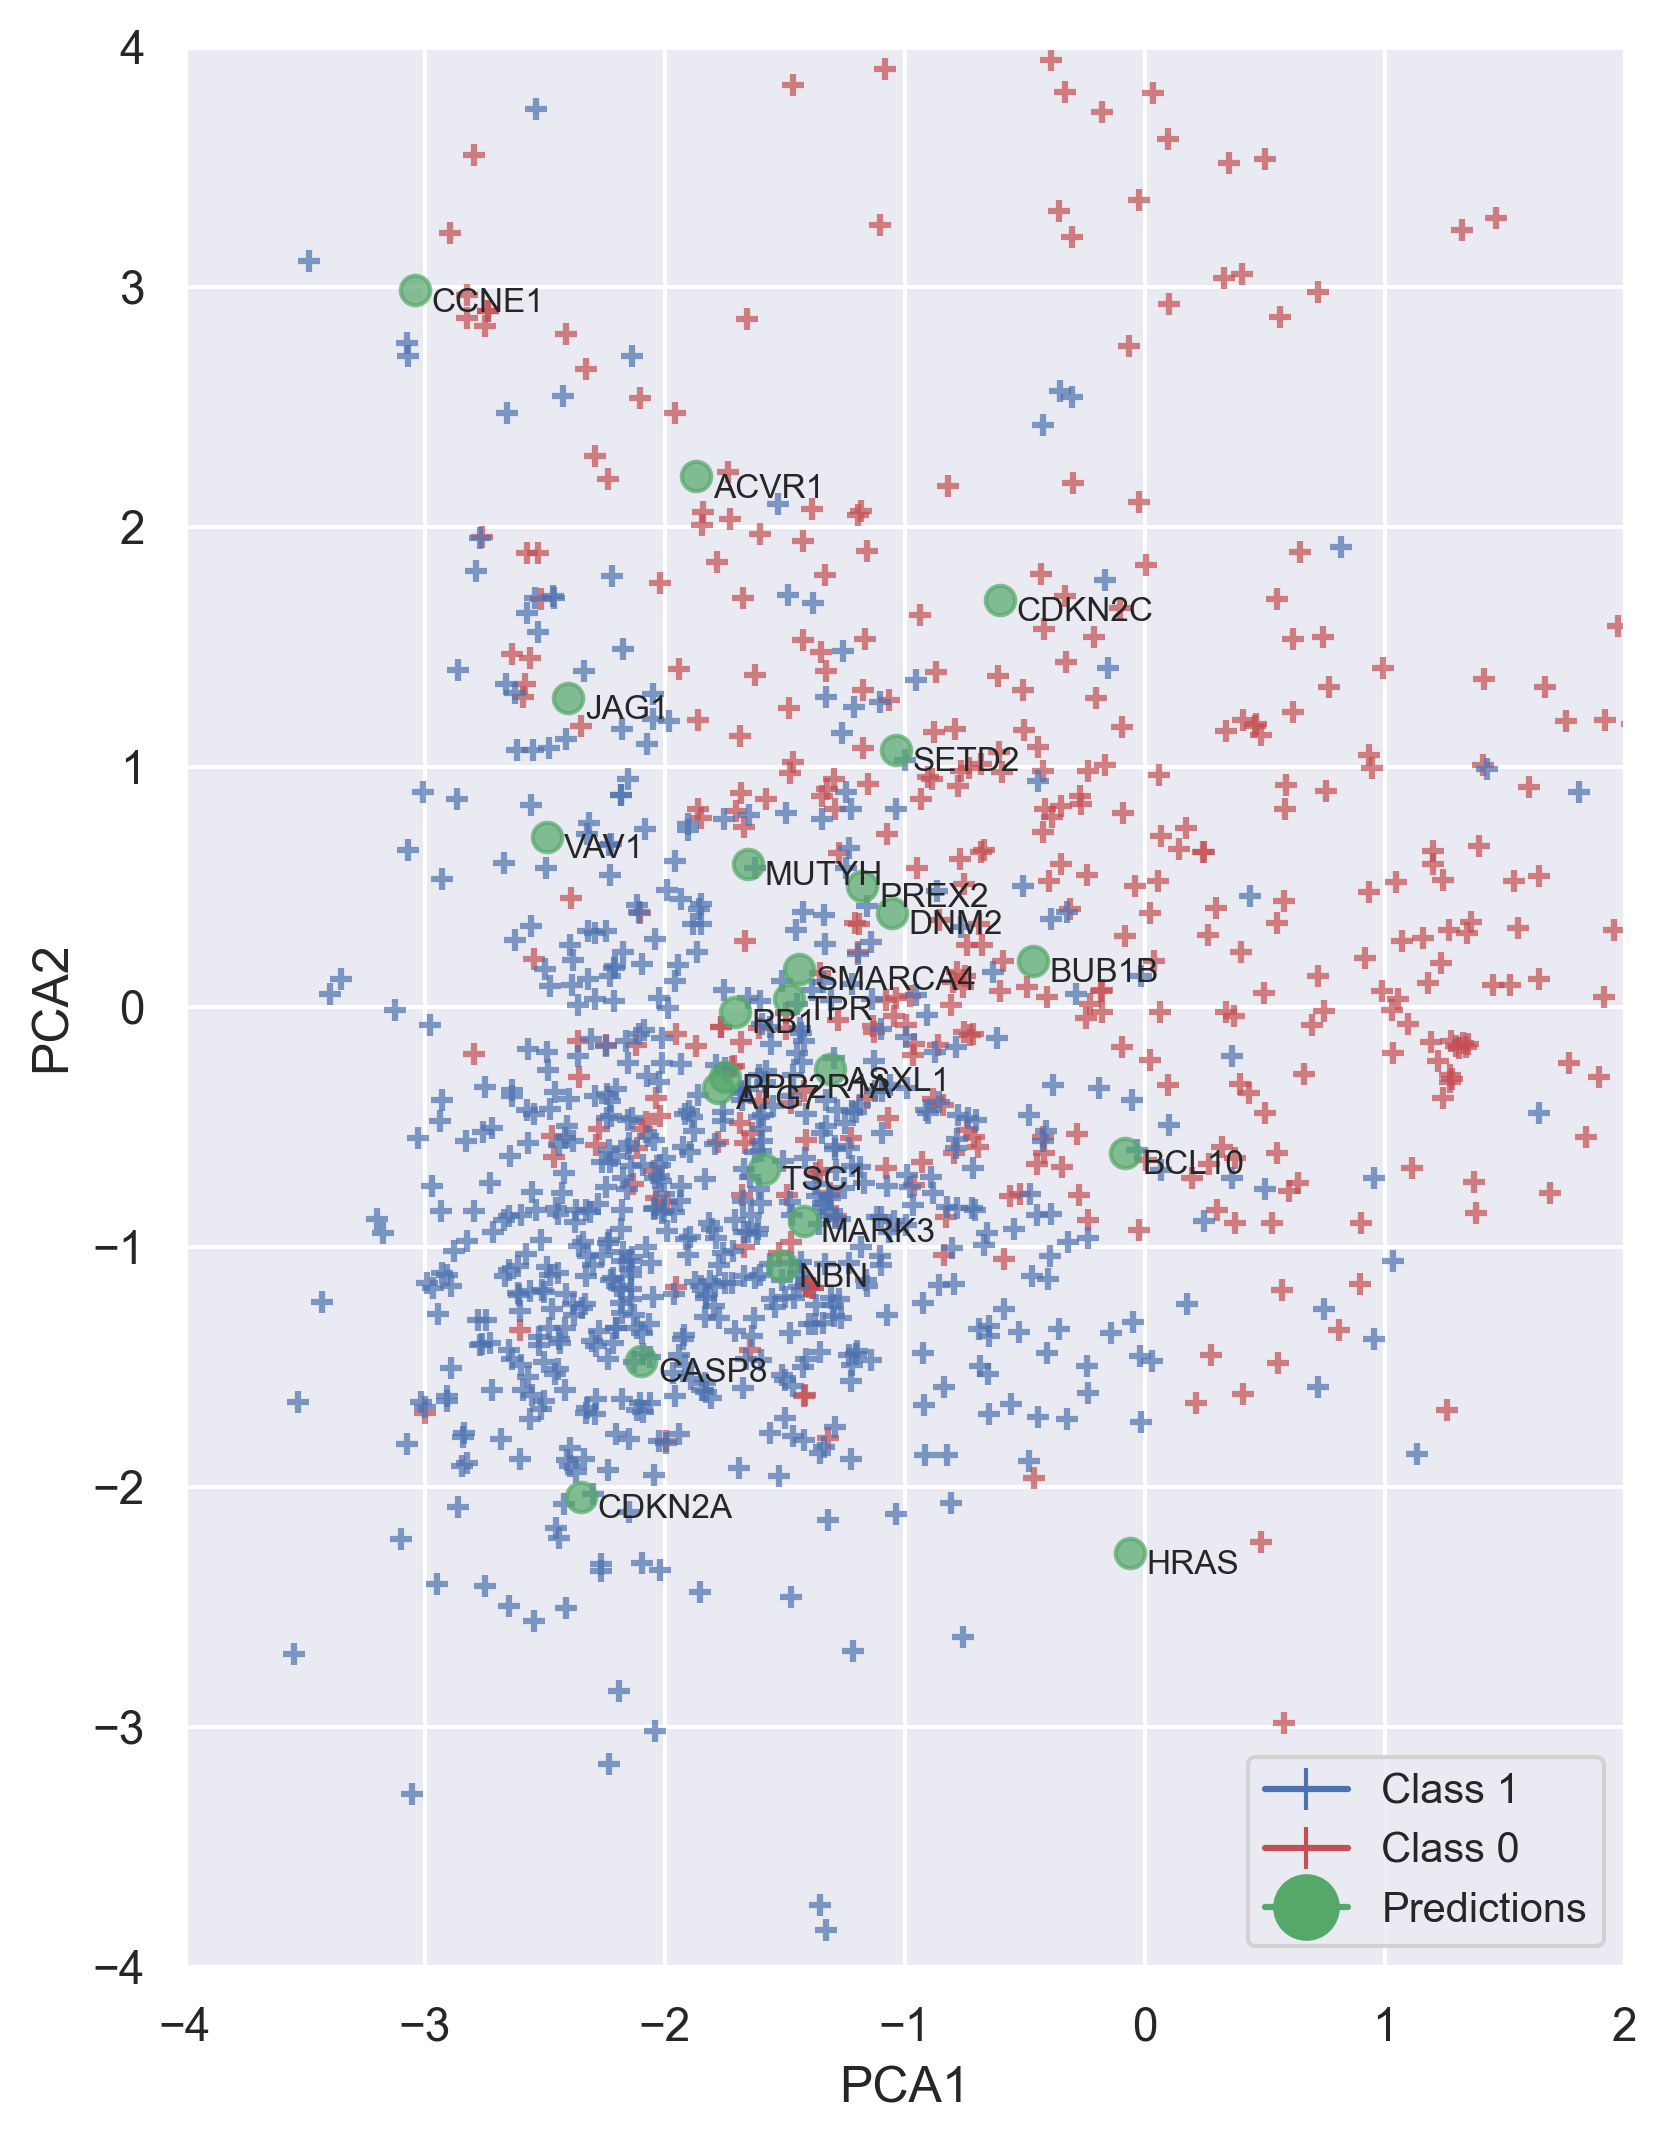

In [44]:
import matplotlib.pyplot as plt
import numpy as np

# Create a figure and a 2D Axes
fig = plt.figure(figsize=(6, 8), dpi=300)  # Adjust figure size and resolution

ax = fig.add_subplot(111)

# Plot the data for Class 0
ax.scatter(df_PCA_All[df_PCA_All['Class']==0]['PCA1'],
           df_PCA_All[df_PCA_All['Class']==0]['PCA2'],
           c='r', alpha=0.7, edgecolors='r', marker='+', s=30)  # Increase marker size

# Plot the data for Class 1
ax.scatter(df_PCA_All[df_PCA_All['Class']==1]['PCA1'],
           df_PCA_All[df_PCA_All['Class']==1]['PCA2'],
           c='b', alpha=0.7, edgecolors='b', marker='+', s=30)  # Increase marker size

# Plot the data for Class -1
for i, row in df_PCA_All[df_PCA_All['Class']==-1].iterrows():
    ax.scatter(row['PCA1'],
               row['PCA2'],
               c='g', alpha=.7, edgecolors='g', marker='o', s=50)  # Increase marker size
    ax.annotate(listGenes[i], (row['PCA1'], row['PCA2']), xytext=(4, -5), textcoords="offset points", fontsize=8)  # Increase font size

# Set the axis labels
ax.set_xlabel('PCA1', fontsize=12)  # Increase font size
ax.set_ylabel('PCA2', fontsize=12)  # Increase font size

# Set the title
# plt.title('2D Plot of PCA1 and PCA2', fontsize=14)  # Add a title and increase font size

# Add a legend
red_patch  = plt.Line2D([0], [0], marker='+', color='r', label='Class 0', markersize=10)  # Increase marker size
blue_patch = plt.Line2D([0], [0], marker='+', color='b', label='Class 1', markersize=10)  # Increase marker size
green_patch = plt.Line2D([0], [0], marker='o', color='g', label='Predictions', markersize=15)  # Increase marker size

ax.legend(handles=[blue_patch, red_patch, green_patch], loc='lower right', fontsize=10)  # Increase font size

# Zoom in on a specific part of the plot
ax.set_xlim(-4, 2)  # Set the x-axis limits
ax.set_ylim(-4, 4)  # Set the y-axis limits

# Adjust the spacing between subplots
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.4, hspace=0.4)

# Save the figure to a file
plt.savefig('./results/PCA_2DwithBestPreds_STD.png', dpi=300, bbox_inches='tight')  # Save the figure with high resolution
#fig.savefig('./results/my_plot.svg', format='svg')

# Show the plot
plt.show()